In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [0]:
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D

In [0]:
from sklearn.metrics import classification_report

## Building a CNN Model


In [0]:
model=Sequential()

In [0]:
model.add(Convolution2D(64,(5,5),input_shape=(48,48,1),activation='relu'))
model.add(Convolution2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Convolution2D(128,(3,3),activation='relu'))
model.add(Convolution2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=7,activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Image Argumentation

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/Training',
        target_size=(48,48),
        batch_size=512,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/content/Testing',
        target_size=(48,48),
        batch_size=512,
        color_mode="grayscale",
        class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [0]:
filepath = os.path.join("./emotion_detector_models/model_v{epoch}.hdf5")

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]

In [0]:
nb_train_samples = 28709
nb_validation_samples = 7178
batch_size=512

In [12]:
history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples// batch_size,
        epochs=50,
        validation_data=validation_generator,
        callbacks = callbacks,
        validation_steps=nb_validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 1.8276 - accuracy: 0.2423
Epoch 00001: val_accuracy improved from -inf to 0.24777, saving model to ./emotion_detector_models/model_v_1.hdf5
56/56 [==============================] - 18s 314ms/step - loss: 1.8276 - accuracy: 0.2423 - val_loss: 1.8138 - val_accuracy: 0.2478
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 1.7829 - accuracy: 0.2603
Epoch 00002: val_accuracy improved from 0.24777 to 0.29548, saving model to ./emotion_detector_models/model_v_2.hdf5
56/56 [==============================] - 18s 322ms/step - loss: 1.7829 - accuracy: 0.2603 - val_loss: 1.7338 - val_accuracy: 0.2955
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 1.7390 - accuracy: 0.2873
Epoch 00003: val_accuracy improved from 0.29548 to 0.30539, saving model to ./emotion_detector_models/model_v_3.hdf5
56/56 [=======================

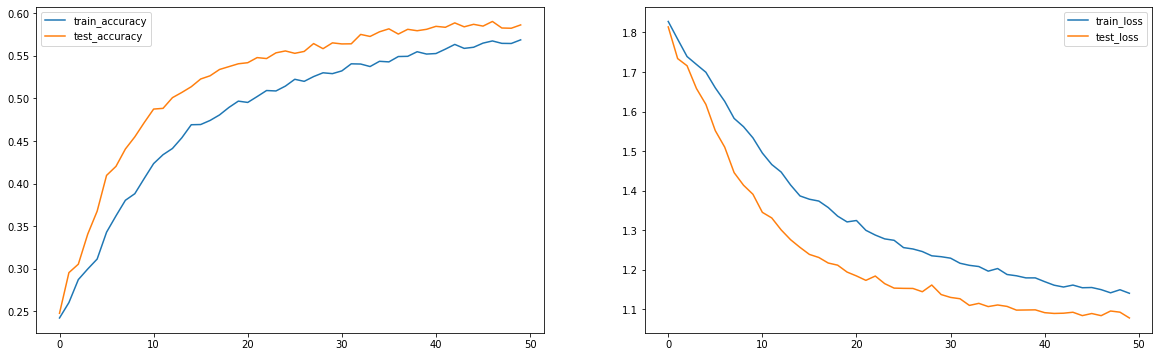

In [13]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,6))
ax1.plot(history.history['accuracy'],label='train_accuracy')
ax1.plot(history.history['val_accuracy'],label='test_accuracy')
ax1.legend()
ax2.plot(history.history['loss'],label='train_loss')
ax2.plot(history.history['val_loss'],label='test_loss')
ax2.legend()
plt.show()

## Predicting And Checking Accuracy

In [14]:
class_labels = train_generator.class_indices
class_labels

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Suprise': 6}

In [15]:
predict_generator = test_datagen.flow_from_directory(
        '/content/Testing',
        target_size=(48,48),
        batch_size=1,
        color_mode="grayscale",
        shuffle = False,
        class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [16]:
Y_pred = model.predict_generator(predict_generator, nb_validation_samples)

Instructions for updating:
Please use Model.predict, which supports generators.


In [0]:
y_pred = np.argmax(Y_pred,axis=1)

In [18]:
len(y_pred)

7178

In [19]:
print(classification_report(predict_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.54      0.50       958
           1       0.66      0.21      0.32       111
           2       0.48      0.23      0.31      1024
           3       0.77      0.86      0.81      1774
           4       0.53      0.56      0.54      1233
           5       0.44      0.51      0.47      1247
           6       0.74      0.71      0.72       831

    accuracy                           0.59      7178
   macro avg       0.58      0.52      0.52      7178
weighted avg       0.58      0.59      0.57      7178



#### The Highest Accuracy obtained using model as 59 %.